In [1]:
import glob 
import numpy as np 
import matplotlib.pyplot as plt


**Load color images**

In [2]:
ColorImage = glob.glob("apples/*.jpg") 

ColorImgs = [] 
for myFile in ColorImage:
    im = plt.imread(myFile)
    im = im/255

    # Current image is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ColorImgs.append(im) 


**Load mask images**

In [3]:
MaskImage = glob.glob("apples/*.png") 

MaskImgs = [] 
for myFile in MaskImage:
    im = plt.imread(myFile) 
    # These mask-images are often 3-channel, and contain grayscale values. 
    # We would prefer 1-channel and just binary:
    im = im[:,:,1] 
    MaskImgs.append(im) 


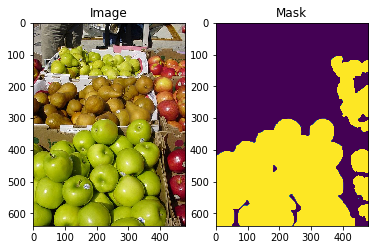

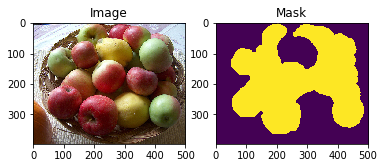

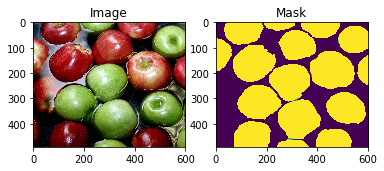

In [4]:
# display the test image and the ground truth mask
for i in range(len(ColorImgs)):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ColorImgs[i])
    ax1.set_title('Image')
    ax2.imshow(MaskImgs[i])
    ax2.set_title('Mask')



 ## <font color='blue'> Comments on diagram
 It shows the color images and mask images of the data set used for training.


**Generate training data** 

The dataset is arranged in a d by n matrix, where d is the dimension of the data and n is the number of the pixels belongs to that data set.

In [5]:
nonApple = []
Apple = []
counterApple = 0
counterNonApple = 0
for i in range(len(ColorImgs)):
    for row in range(MaskImgs[i].shape[0]):
        for col in range(MaskImgs[i].shape[1]):
            # test if the pixel is black
            if(MaskImgs[i][row,col]==0):
                nonApple.append(ColorImgs[i][row,col,:])
                counterNonApple += 1
            else:
                Apple.append(ColorImgs[i][row,col,:])
                counterApple += 1
            ## Apple[i] for the information of i-th apple pixel
            ## nonApple[i] for the infomation of i-th non apple pixel
            ## The infomation is stored in 3x1 format (R,G,B)
            
Apples = np.array(Apple).T  
nonApples = np.array(nonApple).T 



**Method for calculating Multi-dimensional Gaussian function**

It returns a n by 1 vector which contains the likelihood of each data point in the data belong to Gaussian distribution defined by gaussMean and gaussCov

In [6]:
#the goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,mean,cov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    #like = multivariate_normal.pdf(x=data.T, mean=mean, cov=cov)
    d = len(mean)
    mean = np.expand_dims(mean, axis=1)
    data_minus_mean = data - mean
    before_exp = np.double(1/np.power(np.power(2*np.pi, d)*np.linalg.det(cov), 0.5))
    inside_exp = np.sum((data_minus_mean.T @ np.linalg.pinv(cov)) * data_minus_mean.T, axis=1)
    after_exp = np.double(np.exp((-0.5) * inside_exp))
    like = np.double(before_exp * after_exp)
    return like

**Calculate likelihood of pixels** 

It calculate the likelihood of each pixel by combining all the likelihood of different Gaussian models together using weighted sum.

In [7]:
def getMixGaussLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    Like -- n by 1 matrix
    
    """
    # initialize ikelihoods                                                                       
    Like = np.zeros((data.shape[1], ))                                                                               
    for k in range(mixGaussEst['k']):
        prob = calcGaussianProb(data, mixGaussEst['mean'][:,k], mixGaussEst['cov'][:,:,k]) 
        Like += mixGaussEst['weight'][k] * prob  

    return  Like                                                               
                                  

**Method for training a mixture of Gaussian model**

In [8]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    nIter = 100
    
    
    for cIter in range(nIter):
        print('%d-th iteration'%(cIter))

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        # Calculate posterior probability of the each pixel
        # update q(h)
        for i in range(mixGaussEst['k']):
            postHidden[i] = mixGaussEst['weight'][i]*calcGaussianProb(data,mixGaussEst['mean'][:,i], mixGaussEst['cov'][:,:,i])
        
        # postHidden is k by n
        postHidden = postHidden / np.sum(postHidden, axis=0)


        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:])/np.sum(postHidden)
            

            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            # postHidden[cGauss,:] -> postHidden for each data at k = cGauss
            # data -> d x n matrix
            # mixGaussEst['mean'][:,cGauss] -> dx1 
            # we need to consider all the dimension of x 
            # calculate postHidden * data at dimension_i for each dimension 
            mixGaussEst['mean'][:,cGauss] = (postHidden[cGauss,:].reshape(1,nData) @ np.transpose(data))/ np.sum(postHidden[cGauss,:])
            
            
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            # data is a d x n matrix
            # mixGaussEst['cov'][:,:,cGauss] -> dxd
            # Covariance Matrix  
            # mij = cov(data_in_dimension_i, data_in_dimension_j)
            # Covarience between two set of data
            # cov= mij 
            # First, for each dimension of data, calculate the value of data_ith_dimension - mu_i_th_dimension
  
            dataMinusMu = data - np.expand_dims(mixGaussEst['mean'][:,cGauss], axis=1)
            sumDist = postHidden[cGauss]*dataMinusMu@dataMinusMu.T
        
            # Normalize
            mixGaussEst['cov'][:,:,cGauss] = sumDist / np.sum(postHidden[cGauss,:]) 
        
            # avoid unblanced gaussian mixture
            if cGauss > 0:
                for index in range(cGauss):
                    # for the condition that one gaussian only fits a few data
                    for row in range(mixGaussEst['cov'][:,:,index].shape[0]):
                        for col in range(mixGaussEst['cov'][:,:,index].shape[1]):
                            
                            if mixGaussEst['cov'][row,col,index] / mixGaussEst['cov'][row,col,cGauss]>400 :
                                    
                                    print('Re-initialize cov!')
                                    #try sth smaller
                                    mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*0.9
                                    #try sth bigger
                                    mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*1.1
                                    if mixGaussEst['cov'][row,col,cGauss] <= 0.0005:# too small
                                        mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*5
    
                                    
                                    
                                    
                            if mixGaussEst['cov'][row,col,cGauss] / mixGaussEst['cov'][row,col,index] > 400:
                                    print('Re-initialize cov!')
                                    #try sth smaller
                                    mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*0.9
                                    #try sth bigger
                                    mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*1.1
                                    if mixGaussEst['cov'][row,col,index] <= 0.0005: # too small
                                        mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*5                                   

                                    
            
                                

    return mixGaussEst

 ## <font color='blue'> Comments on code
As there is a condition that one or more initial gaussian model only fit a few data, the other Gaussian models may try their best to fit the rest of data. The model will not converge very well at last under this condition. Due to the condition that high covariance always relates to the condition that one gaussian tries to fit the rest of data, I added a test after calculating the covariance. If the covariance of one gaussian model is much higher when it compared to the other ones, the system will re-initialize it. It just like add a little bit noise to the model to let it get better result. The threshold value is determined according to the accuracy of the test on the validation set. 
    
Furthermore, other parameters like the number of the weight and the times of the iteration are also adjusted according to the performance on the validation set. Normally, higher number of weight will introduce higher accuracy and require more iterations to get better performance. However, we should also consider the problem of overfitting which is introduced by too big k (the number of weight).

**Train a mixture of Gaussians model for apples and non-apples pixels**

In [20]:
%time
#define number of components to estimate
nGaussEst = 4

#fit mixture of Gaussians 
appleMixGaussEst = fitMixGauss(Apples,nGaussEst);
nonAppleMixGaussEst = fitMixGauss(nonApples,nGaussEst);

Wall time: 0 ns
0-th iteration
1-th iteration
2-th iteration
3-th iteration
4-th iteration
5-th iteration
6-th iteration
7-th iteration
8-th iteration
9-th iteration
10-th iteration
11-th iteration
12-th iteration
13-th iteration
14-th iteration
15-th iteration
16-th iteration
17-th iteration
18-th iteration
19-th iteration
20-th iteration
21-th iteration
22-th iteration
23-th iteration
24-th iteration
25-th iteration
26-th iteration
27-th iteration
28-th iteration
29-th iteration
30-th iteration
31-th iteration
32-th iteration
33-th iteration
34-th iteration
35-th iteration
36-th iteration
37-th iteration
38-th iteration
39-th iteration
40-th iteration
41-th iteration
42-th iteration
43-th iteration
44-th iteration
45-th iteration
46-th iteration
47-th iteration
48-th iteration
49-th iteration
50-th iteration
51-th iteration
52-th iteration
53-th iteration
54-th iteration
55-th iteration
56-th iteration
57-th iteration
58-th iteration
59-th iteration
60-th iteration
61-th iteration
62

**Load test Images**

In [21]:
testImage = glob.glob("testApples/*.jpg") 

testImgs = [] 
for myFile in testImage:     
    im = plt.imread(myFile)
    im = im/255
    # Current image is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    testImgs.append(im) 


**Calculate posteriors for each pixel**

In [22]:
def CalculatePosterior(testImgs,priorApple):
    # let's define priors for whether the pixel is apple or non apple

    priorNonApple = 1 - priorApple
    posteriorApple = []
    for i in range(len(testImgs)):
        # now run through the pixels in the image and classify them as being apple or non apple 
        im = testImgs[i]
        imY, imX, imZ = im.shape

        im = np.double(im)
        im = np.transpose(im, [2, 0, 1])
        im = np.reshape(im, [im.shape[0], im.shape[1]*im.shape[2]])
        likeApple = getMixGaussLike(im,appleMixGaussEst)
        likeNonApple = getMixGaussLike(im,nonAppleMixGaussEst)
        #posteriorApple = (likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
        posterior = (likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
        posterior = np.reshape(posterior, (imY, imX))
        posteriorApple.append(posterior)
            

    return posteriorApple

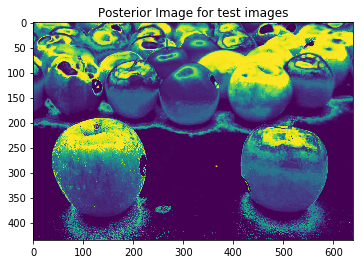

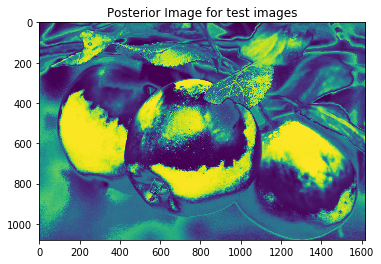

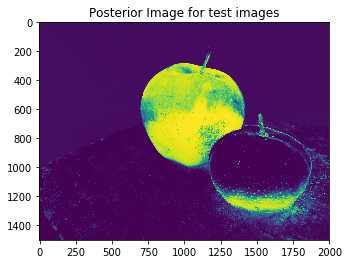

In [23]:
# Calculate prior 
# The prior is calculated by counting the number of data in positive dataset.
priorApple = counterApple/(counterApple+counterNonApple)
# Calculate posterior
posteriorApple = CalculatePosterior(testImgs,priorApple)


for i in range(len(posteriorApple)):
# display the test image and the ground truth mask
    f, (ax) = plt.subplots()
    ax.imshow(posteriorApple[i])
    ax.set_title('Posterior Image for test images')


 ## <font color='blue'> Comments on code
    
The images above shows the posterior probability of each pixel by applying the model. The lighter pixel represents higher posterior probability of being an apple. The darker pixel represents lowe posterior probability of being an apple, that is a non apple pixel. In general, the model can correctly classify pixels.

However, several apple pixels with color which is not the color of the apple used for training in the training dataset are misclassified.  Furthermore, due to the shadow will influence the color of pixel of the object, the shadow has a great influence on the performance of classification. Influence of shadow can be decreaced by introducing the intensity image as an additional channel for the image. 

**Load ground-truth mask**

In [24]:
testMask = glob.glob("testapples/*.png") 
testMasks = [] 
for myFile in testMask:
    im = plt.imread(myFile) 
    # These mask-images are often 3-channel, and contain grayscale values. 
    # We would prefer 1-channel and just binary:
    im = im[:,:,1] 
    testMasks.append(im) 

**Calculate ROC**



In [25]:
def CalROC(groundTruth, estimate): 
    """
    Method for drawing ROC curve which is related to the  
    true positive rate (TPR) and the false positive rate (FPR)
    
    TPR = TP/P = TP/(TP+FN)
    FPR = FP/N = FN/(FN+TN)
    
    where 
    P indicates the number of real positive cases in the data
    N indicates the number of real negative cases in the data
    TP indicates that a pixel is both 1 in the ground truth and the calculated result image
    FP indicates error, that is a pixel is 0 in the ground truth while 1 in the calculated result image
    FN indicates miss, that is a pixel is 1 in the ground truth while 0 in the calculated result image
    TN indicates correct rejection
    
    Keyword arguments:
    groundTruth -- goundtruth mask
    estimate -- calculated result for recognizing apples

    Returns: 
    plot of ROC curve
    
    """

    TPR = []
    FPR = []
    
    result = np.zeros([estimate.shape[0],estimate.shape[1]])
    for threshold in np.arange(0,1,0.1):
        result = np.copy(estimate)
        result[result<=threshold] = 0
        result[result>threshold] = 1
        P = np.sum(groundTruth)
        N = groundTruth.shape[0]*groundTruth.shape[1] - P
        
        #result = groundTruth *result -> like taking the ground truth as a mask to validate
        TP = np.sum(groundTruth * result) # for groundtruth = 1, estimate = 1
        FP = np.sum(result) - TP # for groundtruth = 0, estimate = 1
           
        
        TPR.append(TP/P)
        FPR.append(FP/N)

    
    
    f, (ax) = plt.subplots()
    plt.plot(FPR,TPR)
    ax.set_title('ROC Curve')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    
    


**Display ROC curves for the test images with mask**

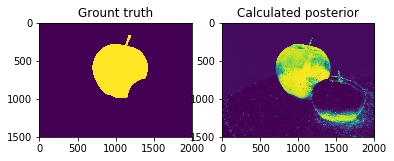

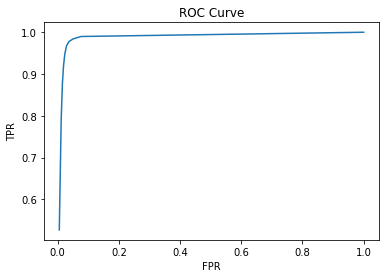

In [26]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(testMasks[0])
ax1.set_title('Grount truth')
ax2.imshow(posteriorApple[2])
ax2.set_title('Calculated posterior')
CalROC(testMasks[0],posteriorApple[2])

## <font color='blue'> Comments on diagram
The ROC curve shows the performance of the model with respect to different threshold values. Ideally, the best possible prediction method would yield a point at (0,1) of the space, which represents the condition that there is no false negative points and no false positive points. Therefore,the curve closer to the point (0,1) represents better performance. 

In [27]:
ColorImage = glob.glob("newApples/*.jpg") 
ValidateImgs = []
for myFile in ColorImage:     
    im = plt.imread(myFile)
    im = im/255
    # Current image is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ValidateImgs.append(im) 



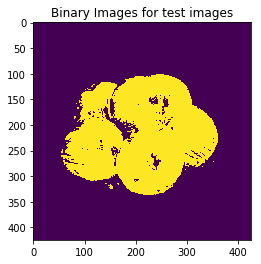

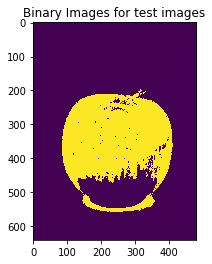

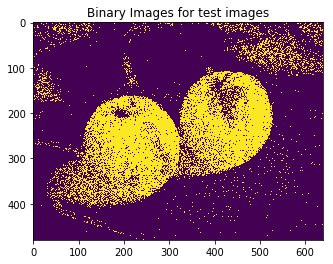

In [28]:
posteriorApple2 = CalculatePosterior(ValidateImgs,priorApple)
for i in range(len(posteriorApple2)):
    binary = np.copy(posteriorApple2[i])
    binary[binary<=0.5] = 0
    binary[binary>0.5] = 1
    f, (ax) = plt.subplots()
    ax.imshow(binary)
    ax.set_title('Binary Images for test images')

Generally, the model can identify apple pixels and non-apple pixels with a high performance. However, it is still influenced by the effect of shadow. Furthermore, the model can identify the pixel which has distinct different color from apple e.g.white as non-apple pixel. Pixels which has similar color with apple my be uncorrectly classified.

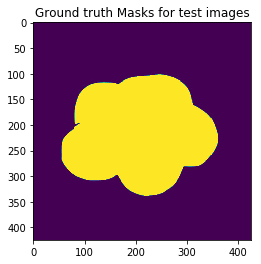

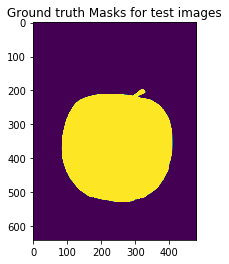

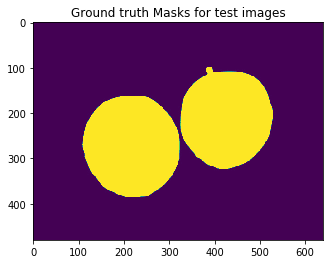

In [29]:
MaskImage = glob.glob("newApples/*.png") 

ValidateMasks = [] 
for myFile in MaskImage:
    im = plt.imread(myFile) 
    # These mask-images are often 3-channel, and contain grayscale values. 
    # We would prefer 1-channel and just binary:
    im = im[:,:,1]
    ValidateMasks.append(im) 
    f, (ax) = plt.subplots()
    ax.imshow(im)
    ax.set_title('Ground truth Masks for test images')
    
    


**Display ROC curves for new images**

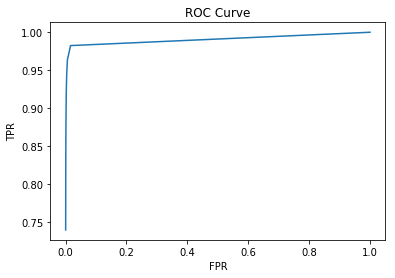

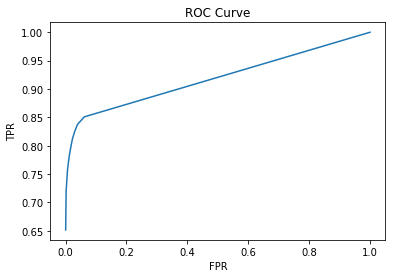

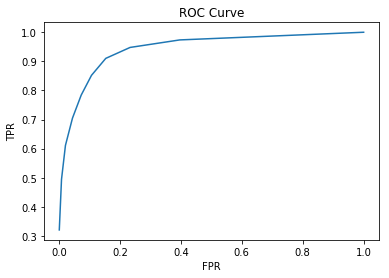

In [30]:
for i in range(len(ValidateMasks)):
    CalROC(ValidateMasks[i],posteriorApple2[i])
    

 ## <font color='blue'> Comments on diagram
The model can model the data with high performance because the ROC curve of each image are all close the the top left point (0,1).When we are adjusting the parameters that are set by user, we can use ROC curve to indentify the parameter which introduce the best performance. 

 ## <font color='blue'> Question: 
**Why we use three separate sets of images: a training set, a validation set and a test set**

Ans:

The training set is used to train the model. After training using the training set, the validation set are used to evaluate the accuracy of the model. For images in the validation set, we know the ground truth. We would adjust parameters that are not learned from the training according to the error of the model which is computed according to the ground truth. If we use the training set as the validation set, the model will overfitting. Therefore, if new images are inputed in the model, the model may wrong classied several pixels.

When it comes to the test of the model, we need to use a new set of images. We use the test to estimate the performance of our final model. We need to know the performance of our model on unseen data.